In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import albumentations as A
import ast
import matplotlib.pyplot as plt
from EDA.EDA import activate_list_in_dataframe

# Config

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 416
scale = 1.1
TRAIN_IMAGE_ROOTPATH = "D:visdrone/VisDrone2019-MOT-train/sequences/"
VAL_IMAGE_ROOTPATH = "D:visdrone/VisDrone2019-MOT-val/sequences/"

# make data generator

In [3]:
train_df = pd.read_csv("EDA/train_det_df.csv")
# val_df = pd.read_csv("EDA/val_det_df.csv")

In [4]:
train_df["img_path"] = train_df["img_path"].apply(lambda x : TRAIN_IMAGE_ROOTPATH+x )
train_df = activate_list_in_dataframe(train_df)
train_df.head(2)

,video_name,frame_index,img_path,coco,xyxy,yolo,height,width,classes,unified_classes
0,uav0000013_00000_v,1,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[424, 543, 35, 88], [416, 530, 36, 85], [591,...","[[424, 543, 459, 631], [416, 530, 452, 615], [...","[[441.5, 587.0, 35, 88], [434.0, 572.5, 36, 85...",756,1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,uav0000013_00000_v,2,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[423, 543, 35, 88], [415, 530, 36, 85], [590,...","[[423, 543, 458, 631], [415, 530, 451, 615], [...","[[440.5, 587.0, 35, 88], [433.0, 572.5, 36, 85...",756,1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [5]:
train_df = train_df[['img_path', 'xyxy','height', 'width', 'classes']]
train_df

,img_path,xyxy,height,width,classes
0,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[424, 543, 459, 631], [416, 530, 452, 615], [...",756,1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[423, 543, 458, 631], [415, 530, 451, 615], [...",756,1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[423, 543, 458, 631], [415, 530, 451, 615], [...",756,1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[423, 543, 458, 631], [415, 530, 451, 615], [...",756,1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[423, 543, 458, 631], [415, 530, 451, 615], [...",756,1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...
24181,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[655, 482, 795, 621], [791, 399, 880, 483], [...",1071,1904,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
24182,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[652, 485, 793, 625], [789, 400, 879, 485], [...",1071,1904,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
24183,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[649, 488, 790, 628], [788, 402, 879, 488], [...",1071,1904,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
24184,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[646, 491, 788, 632], [786, 403, 879, 491], [...",1071,1904,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [7]:
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                A.IAAAffine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", min_visibility=0.4, label_fields=["category_ids"],),
)

test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", min_visibility=0.4, label_fields=["category_ids"]),
)

C:\Users\rh987\AppData\Roaming\Python\Python39\site-packages\albumentations\imgaug\transforms.py:346: FutureWarning: This IAAAffine is deprecated. Please use Affine instead
  warnings.warn("This IAAAffine is deprecated. Please use Affine instead", FutureWarning)


In [8]:
TRAIN_TFRECORD_PATH = "./EDA/train_dataset.tfrecord"
TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 1
IMAGE_SIZE = 416
scale = 1.1

ANCHORS = [
    [[10, 13], [16, 30], [33, 23]],
    [[30, 61], [62, 45], [59,119]],
    [[116, 90], [156, 198], [373, 326]]
]
STRIDES = np.array([8, 16, 32])


NUM_CLASSES = 3

TRAIN_INPUT_SIZE = 416
TRAIN_OUTPUT_SIZE = TRAIN_INPUT_SIZE //STRIDES

ANCHOR_PER_SCALE = 3
MAX_BBOX_PER_SCALE = 100
IOU_ANCHOR_THRESH = 0.3
OUTPUT_LEVELS = STRIDES.shape[0]

In [123]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, transformer, batch_size=4, train=False, size=416):
        self.df = df.reset_index(drop=True)
        self.train = train
        self.batch_size = TRAIN_BATCH_SIZE if train else TEST_BATCH_SIZE
        self.size = TRAIN_INPUT_SIZE
        self.transformer = transformer
        self.train_output_sizes = TRAIN_OUTPUT_SIZE
        self.strides = np.array(STRIDES)
        self.num_classes = NUM_CLASSES
        self.anchors = (np.array(ANCHORS).T/self.strides).T
        self.anchor_per_scale = ANCHOR_PER_SCALE
        self.max_bbox_per_scale = MAX_BBOX_PER_SCALE

    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)

    def on_epoch_end(self):
        if self.train:
            self.df = self.df.sample(frac=1.0).reset_index(drop=True)

    def __getitem__(self, idx):
        image_path_batch = self.df.iloc[idx * self.batch_size:(idx + 1) *self.batch_size].img_path.values
        boxes_batch = self.df.iloc[idx * self.batch_size:(idx + 1) *self.batch_size].xyxy.values
        classes_batch = self.df.iloc[idx * self.batch_size:(idx + 1) *self.batch_size].classes.values
            
        X = np.zeros( (self.batch_size, self.size, self.size, 3) )


        batch_label_sbbox = np.zeros((self.batch_size, self.train_output_sizes[0], self.train_output_sizes[0], self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
        batch_label_mbbox = np.zeros((self.batch_size, self.train_output_sizes[1], self.train_output_sizes[1], self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
        batch_label_lbbox = np.zeros((self.batch_size, self.train_output_sizes[2], self.train_output_sizes[2], self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)

        batch_sbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
        batch_mbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
        batch_lbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)

        exceptions = False
        for i in range(self.batch_size):
            image = cv2.imread(image_path_batch[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            boxes = boxes_batch[i]
            classes = classes_batch[i]
            
            transformed = self.transformer(image=image, bboxes=boxes, category_ids=classes)
            image = transformed["image"] / 255.0
            boxes = np.array(transformed["bboxes"])
            classes = np.array(transformed['category_ids'])[:,np.newaxis]
            labels = np.concatenate([boxes, classes], axis=1)

        return  image, labels

In [124]:
train_gen = DataGenerator(train_df, transformer=train_transforms, batch_size=20, train=True, size=IMAGE_SIZE)

In [127]:
for a,b in train_gen:
    print(a.shape)
    print(b.shape)
    break

(416, 416, 3)
(10, 5)


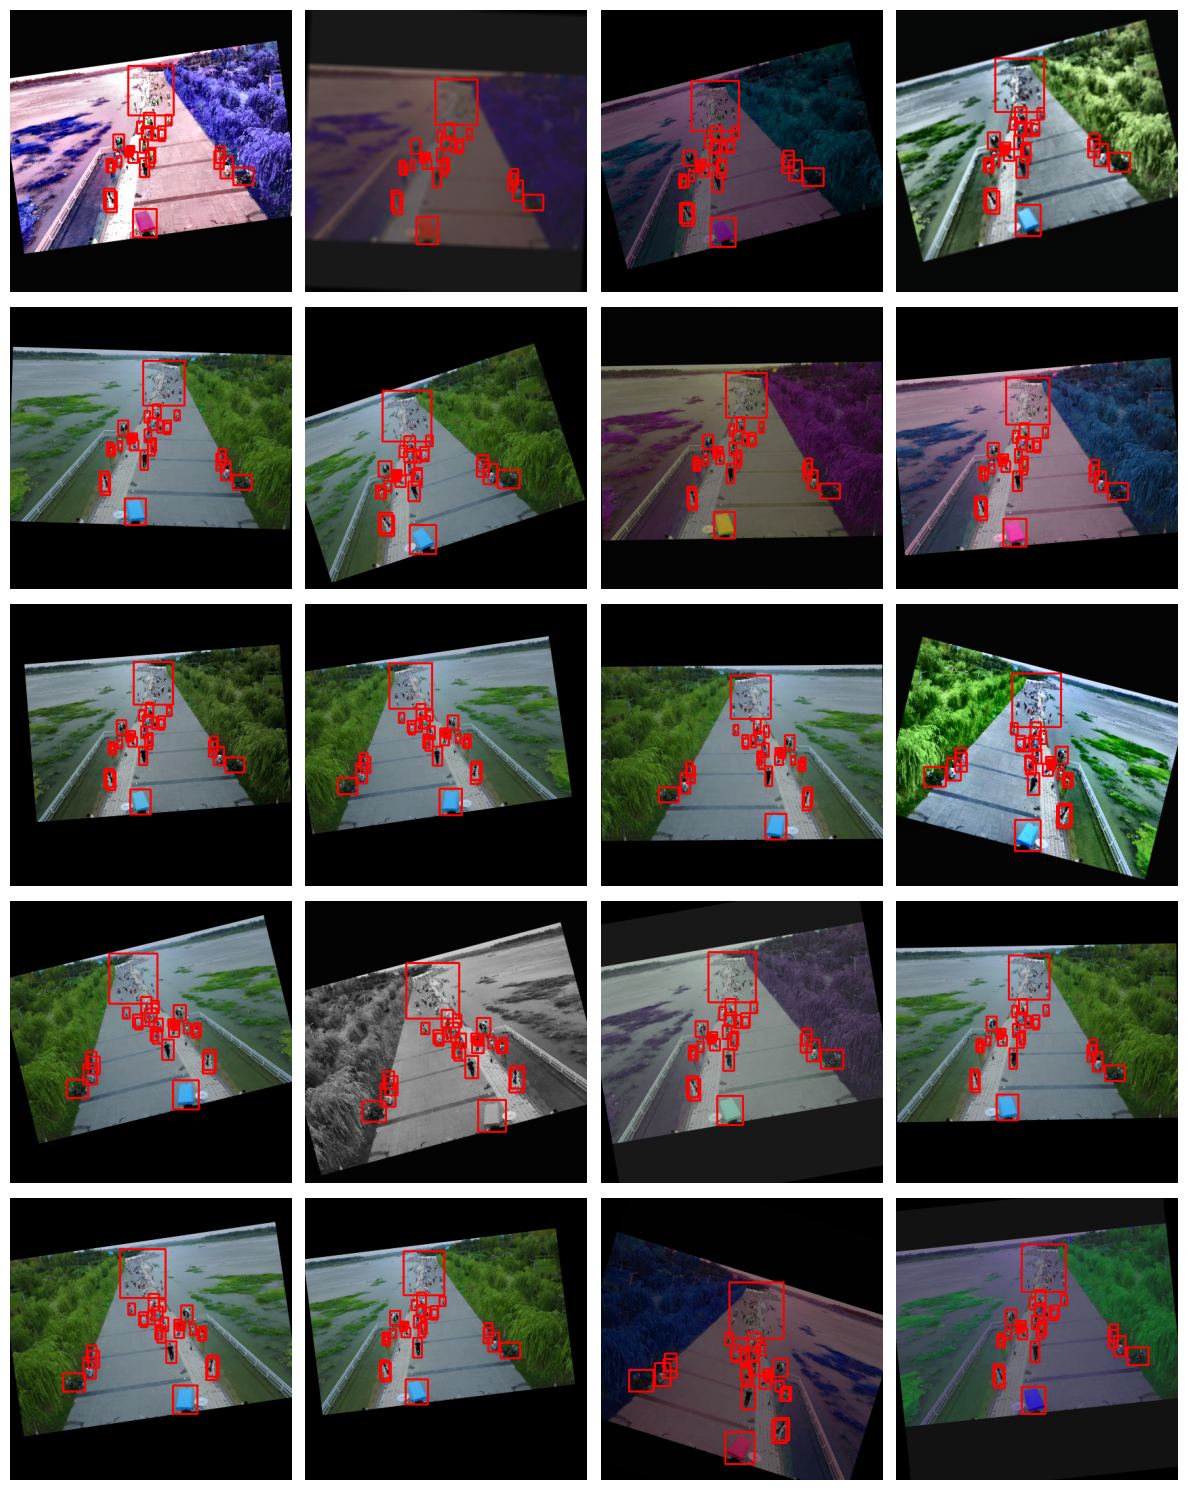

In [314]:
def yolo2xyxy(box):
    x,y,w,h = box
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return x1, y1, x2, y2

def visualize_bbox(img, bbox, color=(255, 0, 0), thickness=2, size=416):
    """Visualizes a single bounding box on the image"""
    bbox = yolo2xyxy(bbox)
    xmin, ymin, xmax, ymax = bbox
    xmin = int(xmin*size)
    ymin = int(ymin*size)
    xmax = int(xmax*size)
    ymax = int(ymax*size)
    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax),color=color,thickness=thickness)
    return img

def visualize(image, bboxes):
    img = image.copy()
    for bbox in bboxes:
        img = visualize_bbox(img, bbox)
    return img

for x,b,c,d in train_gen:
    img_count = x.shape[0]
    col_len = int(img_count // 4)
    col_len = col_len if col_len else 1
    plt.figure(figsize=(12,3*col_len))
    
    for i in range(x.shape[0]):
        image = x[i]*255
        image = image.astype(np.uint8)
        boxes = b[i]
        img = visualize(image, boxes)
        plt.subplot( col_len, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break